# Flight Fare Prediction - Regression type

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
trained = pd.read_excel("Flight_Train_set.xlsx")

In [3]:
test = pd.read_excel("Flight_Test_set.xlsx")

# Clubbing Train and test data together 

In [4]:
df = pd.concat([trained,test], ignore_index = True)

# DATA PREPROCESSING

## To find any missing Values

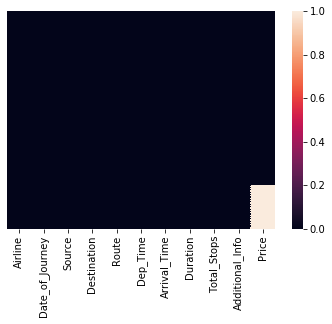

In [5]:
sns.heatmap(df.isnull(), cbar=True, xticklabels=True, yticklabels=False)

In [6]:
df.isnull().sum()

Airline               0
Date_of_Journey       0
Source                0
Destination           0
Route                 1
Dep_Time              0
Arrival_Time          0
Duration              0
Total_Stops           1
Additional_Info       0
Price              2671
dtype: int64

In [7]:
df[df["Route"].isnull()]

,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,Price
9039,Air India,6/05/2019,Delhi,Cochin,NaN,09:45,09:25 07 May,23h 40m,NaN,No info,7480.0


In [26]:
# The Price, Duration, Source, Destination of the missing observation when compared to previous data 
# Missing values of Route can be replaced with "DEL → BOM → COK" with 
# Total_stops as 1

In [8]:
df["Route"].fillna("DEL → BOM → COK",inplace = True)

In [9]:
df["Total_Stops"].fillna("1 stop", inplace = True)

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13354 entries, 0 to 13353
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Airline          13354 non-null  object 
 1   Date_of_Journey  13354 non-null  object 
 2   Source           13354 non-null  object 
 3   Destination      13354 non-null  object 
 4   Route            13354 non-null  object 
 5   Dep_Time         13354 non-null  object 
 6   Arrival_Time     13354 non-null  object 
 7   Duration         13354 non-null  object 
 8   Total_Stops      13354 non-null  object 
 9   Additional_Info  13354 non-null  object 
 10  Price            10683 non-null  float64
dtypes: float64(1), object(10)
memory usage: 1.1+ MB


# Feature Engineering

In [33]:
# Converting Dtypes of Date_of_Journey, Dep_time, Arrival_time, Duration, Total_stops
# ignoring the "year" in Date_of_Journey as the data remains same throughout 

In [11]:
df["Journey_date"] = pd.to_datetime(df["Date_of_Journey"], format = "%d/%m/%Y").dt.day

In [12]:
df["Journey_month"] = pd.to_datetime(df["Date_of_Journey"], format = "%d/%m/%Y").dt.month

In [13]:
df["Dep_hr"] = pd.to_datetime(df["Dep_Time"]).dt.hour

In [14]:
df["Dep_min"] = pd.to_datetime(df["Dep_Time"]).dt.minute

In [15]:
df["Arr_hr"] = pd.to_datetime(df["Arrival_Time"]).dt.hour

In [16]:
df["Arr_min"] = pd.to_datetime(df["Arrival_Time"]).dt.minute

In [17]:
df.drop(["Date_of_Journey","Dep_Time","Arrival_Time","Additional_Info"], axis = 1 ,inplace = True)

In [144]:
#df.Duration.unique()

In [18]:
df["Duration_in_hr"] = df["Duration"].str.split("h").str[0]

In [19]:
df["Duration_in_hr"].unique()

array(['2', '7', '19', '5', '4', '15', '21', '25', '13', '12', '26', '22',
       '23', '20', '10', '6', '11', '8', '16', '3', '27', '1', '14', '9',
       '18', '17', '24', '30', '28', '29', '37', '34', '38', '35', '36',
       '47', '33', '32', '31', '42', '39', '5m', '41', '40'], dtype=object)

In [20]:
df["Duration_in_hr"] = df["Duration_in_hr"].apply(lambda x: x.split("m")[0] if "m" in x else x).astype(int)

In [21]:
df["Duration_in_hr"].unique()

array([ 2,  7, 19,  5,  4, 15, 21, 25, 13, 12, 26, 22, 23, 20, 10,  6, 11,
        8, 16,  3, 27,  1, 14,  9, 18, 17, 24, 30, 28, 29, 37, 34, 38, 35,
       36, 47, 33, 32, 31, 42, 39, 41, 40])

In [22]:
df["Duration_in_min"] = df["Duration"].apply(lambda x: x.split(" ")[-1] if "m" in x else "0m")

In [23]:
df["Duration_in_min"].unique()

array(['50m', '25m', '0m', '45m', '30m', '5m', '15m', '35m', '10m', '20m',
       '55m', '40m'], dtype=object)

In [24]:
df["Duration_in_min"] = df["Duration_in_min"].apply(lambda x: x.split("m")[0]).astype(int)

In [25]:
df["Duration_in_min"].unique()

array([50, 25,  0, 45, 30,  5, 15, 35, 10, 20, 55, 40])

In [26]:
df.Total_Stops.unique()

array(['non-stop', '2 stops', '1 stop', '3 stops', '4 stops'],
      dtype=object)

In [27]:
df["Totalstops"] = df["Total_Stops"].map({'non-stop':0,'2 stops':2, '1 stop':1, '3 stops':3, '4 stops':4})

In [28]:
df["Totalstops"].unique()

array([0, 2, 1, 3, 4], dtype=int64)

In [29]:
df.drop(["Duration","Total_Stops"], axis = 1, inplace = True)

In [152]:
# To fill Test data's Price column based on Train data's Price
# Assuming Airline and Duration have similar air fare Prediction, ignoring distance 

In [30]:
df1 = df.copy()

In [154]:
# Sorting Airline and Duration of the combined dataset, so that Price column can be filled either by
# Forwardfill or Backwardfill

In [31]:
df1.sort_values(["Airline","Duration_in_hr"], ascending = [True, True], inplace =True)

In [32]:
for i in range(1,len(df1.Duration_in_hr)):
    if df1["Duration_in_hr"].iloc[i] == df1["Duration_in_hr"].iloc[i-1]:
        df1["Price"].fillna(method = 'ffill', inplace =True)
    elif df1["Duration_in_hr"].iloc[i] == df1["Duration_in_hr"].iloc[i+1]:
        df1["Price"].fillna(method = 'bfill', inplace =True)

In [33]:
df1["Destination"].unique()

array(['Delhi', 'Banglore', 'New Delhi', 'Cochin', 'Hyderabad', 'Kolkata'],
      dtype=object)

In [34]:
df1["Destination"] = df1["Destination"].replace("New Delhi","Delhi")

In [194]:
## To convert categorical features to numerical features

In [35]:
Airline = df1[["Airline"]]
Airline = pd.get_dummies(Airline,drop_first=True)

In [36]:
Destination = pd.get_dummies(df1[["Destination"]],drop_first = True)

In [37]:
Source = pd.get_dummies(df1[["Source"]],drop_first = True)

In [38]:
df1.drop(["Airline","Destination","Route","Source"], axis = 1, inplace =True)

In [39]:
df2 = pd.concat([df1,Destination,Source, Airline], axis = 1)

# Train Test Split

In [40]:
X = df2.iloc[:,1:]
y = df2.iloc[:,0]

In [41]:
from sklearn.model_selection import train_test_split

In [42]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.3, random_state = 0)

# Feature Selection

In [48]:
#from sklearn.linear_model import Lasso
#from sklearn.feature_selection import SelectFromModel

In [49]:
#mod = SelectFromModel(Lasso(alpha = 0.005,random_state=0))
#mod.fit(X_train,y_train)
#mod.get_support()
#feat = X_train.columns[mod.get_support()]

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 838931150.5697708, tolerance: 19453733.503114752
  positive)


In [50]:
#Diff = set(X.columns) - set(feat)

In [51]:
#Diff

{'Source_Chennai', 'Source_Delhi'}

In [102]:
## Selecting only the features that are important, as a result of Lasso's Feature importance

In [52]:
#X_train.drop(['Source_Chennai', 'Source_Delhi'], axis = 1, inplace = True)

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [53]:
#X_test.drop(['Source_Chennai', 'Source_Delhi'], axis = 1, inplace = True)

In [45]:
X_train.columns

Index(['Journey_date', 'Journey_month', 'Dep_hr', 'Dep_min', 'Arr_hr',
       'Arr_min', 'Duration_in_hr', 'Duration_in_min', 'Totalstops',
       'Destination_Cochin', 'Destination_Delhi', 'Destination_Hyderabad',
       'Destination_Kolkata', 'Source_Chennai', 'Source_Delhi',
       'Source_Kolkata', 'Source_Mumbai', 'Airline_Air India', 'Airline_GoAir',
       'Airline_IndiGo', 'Airline_Jet Airways', 'Airline_Jet Airways Business',
       'Airline_Multiple carriers',
       'Airline_Multiple carriers Premium economy', 'Airline_SpiceJet',
       'Airline_Trujet', 'Airline_Vistara', 'Airline_Vistara Premium economy'],
      dtype='object')

In [43]:
X.head()

,Journey_date,Journey_month,Dep_hr,Dep_min,Arr_hr,Arr_min,Duration_in_hr,Duration_in_min,Totalstops,Destination_Cochin,...,Airline_GoAir,Airline_IndiGo,Airline_Jet Airways,Airline_Jet Airways Business,Airline_Multiple carriers,Airline_Multiple carriers Premium economy,Airline_SpiceJet,Airline_Trujet,Airline_Vistara,Airline_Vistara Premium economy
43,6,5,11,10,13,55,2,45,0,0,...,0,0,0,0,0,0,0,0,0,0
54,3,4,23,55,2,45,2,50,0,0,...,0,0,0,0,0,0,0,0,0,0
189,12,6,11,10,13,55,2,45,0,0,...,0,0,0,0,0,0,0,0,0,0
235,1,5,10,20,12,55,2,35,0,0,...,0,0,0,0,0,0,0,0,0,0
302,12,5,10,20,12,55,2,35,0,0,...,0,0,0,0,0,0,0,0,0,0


# MODEL BUILDING

In [46]:
from sklearn.ensemble import RandomForestRegressor

In [47]:
rfr = RandomForestRegressor()

In [48]:
rfr.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [49]:
rfr.score(X_train,y_train)

0.9364098978045399

In [50]:
rfr.score(X_test,y_test)

0.7036966654988914

In [52]:
ypred5 = rfr.predict(X_test)

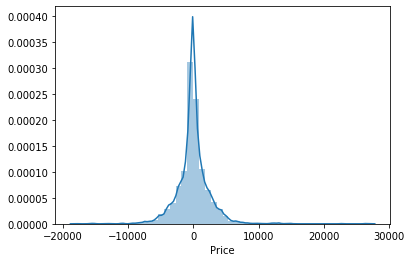

In [53]:
sns.distplot(y_test-ypred5)

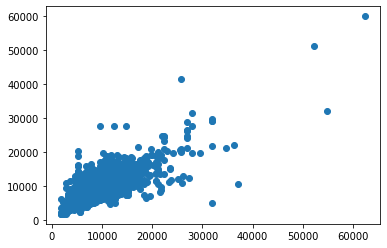

In [54]:
plt.scatter(y_test,ypred5)

In [55]:
from sklearn import metrics
import numpy as np

In [56]:
metrics.mean_absolute_error(y_test, ypred5)

1575.846611438585

In [57]:
metrics.mean_squared_error(y_test,ypred5)

6301820.461828494

In [58]:
np.sqrt(metrics.mean_squared_error(y_test,ypred5))

2510.3426980849636

In [59]:
metrics.r2_score(y_test, ypred5)

0.7036966654988914

# Hyperparameter Tuning

In [60]:
random_grid = {'n_estimators': [int(x) for x in np.linspace(start = 100, stop = 1200, num = 12)],
               'max_features': ['auto', 'sqrt'],
               'max_depth': [int(x) for x in np.linspace(5, 30, num = 6)],
               'min_samples_split': [2, 5, 10, 15, 100],
               'min_samples_leaf': [1, 2, 5, 10]}

In [61]:
from sklearn.model_selection import RandomizedSearchCV

In [62]:
rand_sear = RandomizedSearchCV(rfr,random_grid,scoring = "neg_mean_squared_error", verbose = 2, cv= 5,random_state = 42)

In [63]:
rand_sear.fit(X_train,y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] n_estimators=900, min_samples_split=5, min_samples_leaf=5, max_features=sqrt, max_depth=10 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  n_estimators=900, min_samples_split=5, min_samples_leaf=5, max_features=sqrt, max_depth=10, total=   4.0s
[CV] n_estimators=900, min_samples_split=5, min_samples_leaf=5, max_features=sqrt, max_depth=10 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.9s remaining:    0.0s


[CV]  n_estimators=900, min_samples_split=5, min_samples_leaf=5, max_features=sqrt, max_depth=10, total=   3.8s
[CV] n_estimators=900, min_samples_split=5, min_samples_leaf=5, max_features=sqrt, max_depth=10 
[CV]  n_estimators=900, min_samples_split=5, min_samples_leaf=5, max_features=sqrt, max_depth=10, total=   3.8s
[CV] n_estimators=900, min_samples_split=5, min_samples_leaf=5, max_features=sqrt, max_depth=10 
[CV]  n_estimators=900, min_samples_split=5, min_samples_leaf=5, max_features=sqrt, max_depth=10, total=   3.9s
[CV] n_estimators=900, min_samples_split=5, min_samples_leaf=5, max_features=sqrt, max_depth=10 
[CV]  n_estimators=900, min_samples_split=5, min_samples_leaf=5, max_features=sqrt, max_depth=10, total=   3.9s
[CV] n_estimators=1100, min_samples_split=10, min_samples_leaf=2, max_features=sqrt, max_depth=15 
[CV]  n_estimators=1100, min_samples_split=10, min_samples_leaf=2, max_features=sqrt, max_depth=15, total=   5.9s
[CV] n_estimators=1100, min_samples_split=10, mi

[CV]  n_estimators=700, min_samples_split=10, min_samples_leaf=2, max_features=sqrt, max_depth=5, total=   2.0s
[CV] n_estimators=700, min_samples_split=10, min_samples_leaf=2, max_features=sqrt, max_depth=5 
[CV]  n_estimators=700, min_samples_split=10, min_samples_leaf=2, max_features=sqrt, max_depth=5, total=   2.0s
[CV] n_estimators=700, min_samples_split=10, min_samples_leaf=2, max_features=sqrt, max_depth=5 
[CV]  n_estimators=700, min_samples_split=10, min_samples_leaf=2, max_features=sqrt, max_depth=5, total=   2.0s
[CV] n_estimators=700, min_samples_split=10, min_samples_leaf=2, max_features=sqrt, max_depth=5 
[CV]  n_estimators=700, min_samples_split=10, min_samples_leaf=2, max_features=sqrt, max_depth=5, total=   2.0s
[CV] n_estimators=700, min_samples_split=10, min_samples_leaf=2, max_features=sqrt, max_depth=5 
[CV]  n_estimators=700, min_samples_split=10, min_samples_leaf=2, max_features=sqrt, max_depth=5, total=   1.9s
[CV] n_estimators=700, min_samples_split=15, min_sam

[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:  4.7min finished


RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=RandomForestRegressor(bootstrap=True,
                                                   ccp_alpha=0.0,
                                                   criterion='mse',
                                                   max_depth=None,
                                                   max_features='auto',
                                                   max_leaf_nodes=None,
                                                   max_samples=None,
                                                   min_impurity_decrease=0.0,
                                                   min_impurity_split=None,
                                                   min_samples_leaf=1,
                                                   min_samples_split=2,
                                                   min_weight_fraction_leaf=0.0,
                                                   n_estimators=100,
                              

In [64]:
rand_sear.best_params_

{'n_estimators': 700,
 'min_samples_split': 15,
 'min_samples_leaf': 1,
 'max_features': 'auto',
 'max_depth': 20}

In [65]:
ypred6 = rand_sear.predict(X_test)

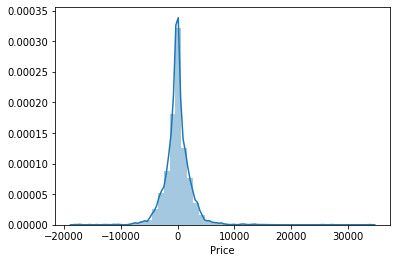

In [66]:
sns.distplot(y_test-ypred6)

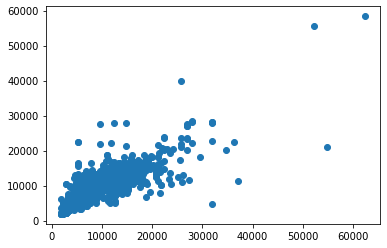

In [67]:
plt.scatter(y_test,ypred6)

In [68]:
metrics.mean_absolute_error(y_test,ypred6)

1496.240205588133

In [69]:
metrics.mean_squared_error(y_test,ypred6)

5778729.017763868

In [70]:
np.sqrt(metrics.mean_squared_error(y_test,ypred6))

2403.89871204339

In [71]:
metrics.r2_score(y_test, ypred6)

0.7282917392659369

In [72]:
import pickle

In [74]:
pickle.dump(rand_sear,open("FlightFare-RandomForest.pkl","wb"))

In [86]:
model = pickle.load(open("FlightFare-RandomForest.pkl","rb")) # for testing#